# RESNET

### 1.1: Flipped input, depth=18, batch_size=4, lr=1e-5, class weighting, loss, accuracy, precision, recall, F1, and ROC AUC, k-fold training, k-fold entry point 

In [ ]:
import os
import time
import psutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import sys
sys.path.append("../3D-CNN-PyTorch")
from models import resnet

import nibabel as nib
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import json


LABEL_MAP = {
    'Good': 1,
    'Acceptable': 0,
    'Poor': 0,
    'Missed': 0
}

class MRIDataset(Dataset):
    def __init__(self, label_csv="../preliminary_automatic_segmentations_quality_scores.csv"):
        self.image_root = "../images"
        self.mask_root = "../segmentations/automatic"

        # Load labels
        df = pd.read_csv(label_csv)
        self.labels = {}
        for _, row in df.iterrows():
            pid = row['patient_id']
            score1 = LABEL_MAP.get(row['expert_1_qs'], 0)
            score2 = LABEL_MAP.get(row['expert_2_qs'], 0)
            label = 1 if (score1 == 1 and score2 == 1) else 0
            self.labels[pid] = label

        self.patient_ids = []
        self.missing_patients = []

        all_patients = [pid for pid in os.listdir(self.image_root)
                        if pid.startswith("DUKE_") and os.path.isdir(os.path.join(self.image_root, pid))]

        for pid in sorted(all_patients):
            if pid not in self.labels:
                continue

            image_path = os.path.join(self.image_root, pid, f"{pid}_0001_n4_denoised_resampled_padded_flipped_LR.nii.gz")
            mask_path = os.path.join(self.mask_root, f"{pid}_processed_flipped_LR.nii.gz")

            if os.path.exists(image_path) and os.path.exists(mask_path):
                self.patient_ids.append(pid)
            else:
                self.missing_patients.append(pid)

        print(f"[INFO] Valid DUKE patients with data: {len(self.patient_ids)}", flush=True)
        if self.missing_patients:
            print(f"[WARN] Skipped {len(self.missing_patients)} patients due to missing files:")
            for pid in self.missing_patients:
                print(f"  - Missing files for {pid}", flush=True)

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]

        image_path = os.path.join(self.image_root, patient_id, f"{patient_id}_0001_n4_denoised_resampled_padded.nii.gz")
        mask_path = os.path.join(self.mask_root, f"{patient_id}_processed.nii.gz")

        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        # Normalize image
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        # Stack image + mask as 2 channels
        data = np.stack([image, mask], axis=0)
        tensor = torch.tensor(data, dtype=torch.float32)

        label = torch.tensor(self.labels[patient_id], dtype=torch.float32)

        if idx % 10 == 0:
            print(f"[DATA] Loaded {patient_id} | Shape: {tensor.shape}", flush=True)

        return tensor, label

# ---------- Model ----------
def generate_model():
    print("[MODEL] Initializing ResNet model...", flush=True)
    model = resnet.generate_model(
        model_depth=18,
        n_input_channels=2,
        n_classes=1,
        conv1_t_size=7,
        conv1_t_stride=1,
        no_max_pool=False,
        shortcut_type='B',
        widen_factor=1.0
    )
    print("[MODEL] Model initialized.", flush=True)
    return model

# ---------- Training ----------
def train_single_gpu():
    print("[MAIN] Starting training script...", flush=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[MAIN] Using device: {device}", flush=True)

    print("[DATA] Loading dataset...", flush=True)
    full_dataset = MRIDataset()

    print("[DATA] Splitting into train/val sets...", flush=True)
    val_size = int(0.2 * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    print(f"[DATA] Train size: {train_size}, Val size: {val_size}", flush=True)

    print("[DATA] Initializing dataloaders...", flush=True)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)
    print("[DATA] Dataloaders ready.", flush=True)

    print("[MODEL] Generating model...", flush=True)
    model = generate_model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    # Pos weight = (negative samples) / (positive samples)
    pos_weight = torch.tensor([0.2736 / 0.7264], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    torch.backends.cudnn.benchmark = True
    start_time = time.time()

    num_epochs = 10  # ✅ Fixed indentation

    print("[TRAIN] Starting training loop...", flush=True)
    for epoch in range(num_epochs):
        print(f"\n[TRAIN] === Epoch {epoch+1}/{num_epochs} ===", flush=True)
        torch.cuda.reset_peak_memory_stats()
        model.train()

        for i, (inputs, labels) in enumerate(train_loader):
            batch_start = time.time()
            print(f"[TRAIN] --- Batch {i} ---", flush=True)
            inputs, labels = inputs.to(device), labels.to(device).view(-1)

            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            try:
                loss.backward()
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print("[ERROR] CUDA out of memory during backward pass.", flush=True)
                    exit(1)
                else:
                    raise

            optimizer.step()

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            targets = labels.detach().cpu().numpy()
            print(f"[TRAIN][Epoch {epoch+1}][Batch {i:03d}] Loss: {loss.item():.4f} | Preds: {np.round(preds, 2)} | Targets: {targets}", flush=True)
            print(f"[TRAIN] Batch {i} complete. Time: {time.time() - batch_start:.2f}s\n", flush=True)

        # ---------- Validation ----------
        print(f"[VAL] Starting validation for epoch {epoch+1}...", flush=True)
        model.eval()
        val_losses = []
        val_correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                if i % 10 == 0:
                    print(f"[VAL] Batch {i}", flush=True)
                inputs, labels = inputs.to(device), labels.to(device).view(-1)
                outputs = model(inputs).view(-1)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())

                preds = (torch.sigmoid(outputs) > 0.5).long()
                val_correct += (preds == labels.long()).sum().item()

                all_preds.extend(preds.detach().cpu().numpy())
                all_targets.extend(labels.detach().cpu().numpy())

        val_loss = np.mean(val_losses)
        val_acc = val_correct / len(val_dataset)
        val_precision = precision_score(all_targets, all_preds)
        val_recall = recall_score(all_targets, all_preds)
        val_f1 = f1_score(all_targets, all_preds)
        val_roc_auc = roc_auc_score(all_targets, all_preds)

        print(f"[VAL][Epoch {epoch+1}] Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_roc_auc:.4f}", flush=True)

        scheduler.step(val_loss)

        # GPU Memory Reporting
        peak_mem = torch.cuda.max_memory_allocated() / 1e6  # MB
        print(f"[RESOURCE][Epoch {epoch+1}] GPU Peak Memory: {peak_mem:.2f} MB", flush=True)

        # Save checkpoint
        os.makedirs("checkpoints", exist_ok=True)
        checkpoint_path = f"checkpoints/resnet_single_gpu_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"[SAVE] Model checkpoint saved to '{checkpoint_path}'", flush=True)

    total_time = time.time() - start_time
    print(f"[TIME] Total training time: {total_time:.2f} seconds", flush=True)


def get_last_completed_fold(checkpoint_dir="checkpoints", prefix="resnet_kfold"):
    completed = []
    if os.path.exists(checkpoint_dir):
        for fname in os.listdir(checkpoint_dir):
            if fname.startswith(prefix) and fname.endswith(".pth"):
                try:
                    fold_num = int(fname.replace(prefix, "").replace(".pth", ""))
                    completed.append(fold_num)
                except ValueError:
                    continue
    return max(completed) if completed else 0

def train_kfold(num_folds=5):
    print(f"[MAIN] Starting {num_folds}-fold cross-validation...", flush=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[MAIN] Using device: {device}", flush=True)

    print("[DATA] Loading dataset...", flush=True)
    full_dataset = MRIDataset()
    labels = [full_dataset.labels[pid] for pid in full_dataset.patient_ids]

    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    last_completed = get_last_completed_fold()
    print(f"[RESUME] Last completed fold: {last_completed}", flush=True)

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        if fold < last_completed:
            print(f"[RESUME] Skipping fold {fold+1} (already completed)", flush=True)
            continue
        print(f"\n[CV] Fold {fold+1}/{num_folds}", flush=True)
        train_subset = torch.utils.data.Subset(full_dataset, train_idx)
        val_subset = torch.utils.data.Subset(full_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
        val_loader = DataLoader(val_subset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

        model = generate_model().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        pos_weight = torch.tensor([0.2736 / 0.7264], device=device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

        num_epochs = 10
        for epoch in range(num_epochs):
            print(f"\n[TRAIN][Fold {fold+1}] === Epoch {epoch+1}/{num_epochs} ===", flush=True)
            model.train()
            train_losses = []
            train_correct = 0
            train_total = 0
            for i, (inputs, labels_) in enumerate(train_loader):
                inputs, labels_ = inputs.to(device), labels_.to(device).view(-1)
                outputs = model(inputs).view(-1)
                loss = criterion(outputs, labels_)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Track loss and accuracy
                train_losses.append(loss.item())
                preds = (torch.sigmoid(outputs) > 0.5).long()
                train_correct += (preds == labels_.long()).sum().item()
                train_total += labels_.size(0)

            train_loss = np.mean(train_losses)
            train_acc = train_correct / train_total if train_total > 0 else 0.0
            print(f"[TRAIN][Fold {fold+1}][Epoch {epoch+1}] Loss: {train_loss:.4f} | Acc: {train_acc:.4f}", flush=True)

            # Validation
            model.eval()
            val_losses = []
            val_correct = 0
            all_labels = []
            all_preds = []
            all_probs = []
            with torch.no_grad():
                for i, (inputs, labels_) in enumerate(val_loader):
                    inputs, labels_ = inputs.to(device), labels_.to(device).view(-1)
                    outputs = model(inputs).view(-1)
                    loss = criterion(outputs, labels_)
                    val_losses.append(loss.item())
                    probs = torch.sigmoid(outputs)
                    preds = (probs > 0.5).long()
                    val_correct += (preds == labels_.long()).sum().item()
                    all_labels.extend(labels_.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())
            val_loss = np.mean(val_losses)
            val_acc = val_correct / len(val_subset)

            # Compute metrics
            precision = precision_score(all_labels, all_preds, zero_division=0)
            recall = recall_score(all_labels, all_preds, zero_division=0)
            f1 = f1_score(all_labels, all_preds, zero_division=0)
            try:
                auc = roc_auc_score(all_labels, all_probs)
            except ValueError:
                auc = float('nan')

            print(f"[VAL][Fold {fold+1}][Epoch {epoch+1}] Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | "
                  f"Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}", flush=True)
            scheduler.step(val_loss)

        # Save checkpoint for this fold
        os.makedirs("checkpoints", exist_ok=True)
        checkpoint_path = f"checkpoints/resnet_kfold{fold+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"[SAVE] Fold {fold+1} model checkpoint saved to '{checkpoint_path}'", flush=True)

def train_from_json_split(json_path="fold2_patient_ids.json", num_epochs=10):
    print(f"[MAIN] Training using split from {json_path}...", flush=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[MAIN] Using device: {device}", flush=True)

    # Load patient IDs from JSON
    with open(json_path, "r") as f:
        split = json.load(f)
    train_ids = set(split["train"])
    val_ids = set(split["val"])

    # Load full dataset
    full_dataset = MRIDataset()
    # Map patient_id to index in full_dataset.patient_ids
    pid_to_idx = {pid: idx for idx, pid in enumerate(full_dataset.patient_ids)}
    train_indices = [pid_to_idx[pid] for pid in train_ids if pid in pid_to_idx]
    val_indices = [pid_to_idx[pid] for pid in val_ids if pid in pid_to_idx]

    train_subset = torch.utils.data.Subset(full_dataset, train_indices)
    val_subset = torch.utils.data.Subset(full_dataset, val_indices)

    train_loader = DataLoader(train_subset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)

    model = generate_model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    pos_weight = torch.tensor([0.2736 / 0.7264], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    print("[TRAIN] Starting training loop...", flush=True)
    for epoch in range(num_epochs):
        print(f"\n[TRAIN][JSON] === Epoch {epoch+1}/{num_epochs} ===", flush=True)
        model.train()
        train_losses = []
        train_correct = 0
        train_total = 0
        for i, (inputs, labels_) in enumerate(train_loader):
            inputs, labels_ = inputs.to(device), labels_.to(device).view(-1)
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels_)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            preds = (torch.sigmoid(outputs) > 0.5).long()
            train_correct += (preds == labels_.long()).sum().item()
            train_total += labels_.size(0)

        train_loss = np.mean(train_losses)
        train_acc = train_correct / train_total if train_total > 0 else 0.0
        print(f"[TRAIN][JSON][Epoch {epoch+1}] Loss: {train_loss:.4f} | Acc: {train_acc:.4f}", flush=True)

        # Validation
        model.eval()
        val_losses = []
        val_correct = 0
        all_labels = []
        all_preds = []
        all_probs = []
        with torch.no_grad():
            for i, (inputs, labels_) in enumerate(val_loader):
                inputs, labels_ = inputs.to(device), labels_.to(device).view(-1)
                outputs = model(inputs).view(-1)
                loss = criterion(outputs, labels_)
                val_losses.append(loss.item())
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).long()
                val_correct += (preds == labels_.long()).sum().item()
                all_labels.extend(labels_.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        val_loss = np.mean(val_losses)
        val_acc = val_correct / len(val_subset)

        # Compute metrics
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
        try:
            auc = roc_auc_score(all_labels, all_probs)
        except ValueError:
            auc = float('nan')

        print(f"[VAL][JSON][Epoch {epoch+1}] Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | "
              f"Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}", flush=True)
        scheduler.step(val_loss)

        # Save checkpoint for this epoch
        os.makedirs("checkpoints", exist_ok=True)
        checkpoint_path = f"checkpoints/resnet_json_fold2_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"[SAVE] Epoch {epoch+1} model checkpoint saved to '{checkpoint_path}'", flush=True)

# ---------- Entry Point ----------
if __name__ == "__main__":
    print("[MAIN] Calling train_from_json_split()...", flush=True)
    train_from_json_split("fold2_patient_ids.json", num_epochs=10)


### 1.0

In [ ]:
import os
import time
import psutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import sys
sys.path.append("../3D-CNN-PyTorch")
from models import resnet

import nibabel as nib
import pandas as pd


LABEL_MAP = {
    'Good': 1,
    'Acceptable': 0,
    'Poor': 0,
    'Missed': 0
}

class MRIDataset(Dataset):
    def __init__(self, label_csv="../preliminary_automatic_segmentations_quality_scores.csv"):
        self.image_root = "../images"
        self.mask_root = "../segmentations/automatic"

        # Load labels
        df = pd.read_csv(label_csv)
        self.labels = {}
        for _, row in df.iterrows():
            pid = row['patient_id']
            score1 = LABEL_MAP.get(row['expert_1_qs'], 0)
            score2 = LABEL_MAP.get(row['expert_2_qs'], 0)
            label = 1 if (score1 == 1 and score2 == 1) else 0
            self.labels[pid] = label

        self.patient_ids = []
        self.missing_patients = []

        all_patients = [pid for pid in os.listdir(self.image_root)
                        if pid.startswith("DUKE_") and os.path.isdir(os.path.join(self.image_root, pid))]

        for pid in sorted(all_patients):
            if pid not in self.labels:
                continue

            image_path = os.path.join(self.image_root, pid, f"{pid}_0001_n4_denoised_resampled_padded.nii.gz")
            mask_path = os.path.join(self.mask_root, f"{pid}_processed.nii.gz")

            if os.path.exists(image_path) and os.path.exists(mask_path):
                self.patient_ids.append(pid)
            else:
                self.missing_patients.append(pid)

        print(f"[INFO] Valid DUKE patients with data: {len(self.patient_ids)}", flush=True)
        if self.missing_patients:
            print(f"[WARN] Skipped {len(self.missing_patients)} patients due to missing files:")
            for pid in self.missing_patients:
                print(f"  - Missing files for {pid}", flush=True)

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]

        image_path = os.path.join(self.image_root, patient_id, f"{patient_id}_0001_n4_denoised_resampled_padded.nii.gz")
        mask_path = os.path.join(self.mask_root, f"{patient_id}_processed.nii.gz")

        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        # Normalize image
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        # Stack image + mask as 2 channels
        data = np.stack([image, mask], axis=0)
        tensor = torch.tensor(data, dtype=torch.float32)

        label = torch.tensor(self.labels[patient_id], dtype=torch.float32)

        if idx % 10 == 0:
            print(f"[DATA] Loaded {patient_id} | Shape: {tensor.shape}", flush=True)

        return tensor, label

# ---------- Model ----------
def generate_model():
    print("[MODEL] Initializing ResNet model...", flush=True)
    model = resnet.generate_model(
        model_depth=50,
        n_input_channels=2,
        n_classes=1,
        conv1_t_size=7,
        conv1_t_stride=1,
        no_max_pool=False,
        shortcut_type='B',
        widen_factor=1.0
    )
    print("[MODEL] Model initialized.", flush=True)
    return model

# ---------- Training ----------
def train_single_gpu():
    print("[MAIN] Starting training script...", flush=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[MAIN] Using device: {device}", flush=True)

    print("[DATA] Loading dataset...", flush=True)
    full_dataset = MRIDataset()

    print("[DATA] Splitting into train/val sets...", flush=True)
    val_size = int(0.2 * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    print(f"[DATA] Train size: {train_size}, Val size: {val_size}", flush=True)

    print("[DATA] Initializing dataloaders...", flush=True)
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    print("[DATA] Dataloaders ready.", flush=True)

    print("[MODEL] Generating model...", flush=True)
    model = generate_model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    torch.backends.cudnn.benchmark = True
    start_time = time.time()

    num_epochs = 10  # ✅ Fixed indentation

    print("[TRAIN] Starting training loop...", flush=True)
    for epoch in range(num_epochs):
        print(f"\n[TRAIN] === Epoch {epoch+1}/{num_epochs} ===", flush=True)
        torch.cuda.reset_peak_memory_stats()
        model.train()

        for i, (inputs, labels) in enumerate(train_loader):
            batch_start = time.time()
            print(f"[TRAIN] --- Batch {i} ---", flush=True)
            inputs, labels = inputs.to(device), labels.to(device).view(-1)

            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            try:
                loss.backward()
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print("[ERROR] CUDA out of memory during backward pass.", flush=True)
                    exit(1)
                else:
                    raise

            optimizer.step()

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            targets = labels.detach().cpu().numpy()
            print(f"[TRAIN][Epoch {epoch+1}][Batch {i:03d}] Loss: {loss.item():.4f} | Preds: {np.round(preds, 2)} | Targets: {targets}", flush=True)
            print(f"[TRAIN] Batch {i} complete. Time: {time.time() - batch_start:.2f}s\n", flush=True)

        # ---------- Validation ----------
        print(f"[VAL] Starting validation for epoch {epoch+1}...", flush=True)
        model.eval()
        val_losses = []
        val_correct = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                if i % 10 == 0:
                    print(f"[VAL] Batch {i}", flush=True)
                inputs, labels = inputs.to(device), labels.to(device).view(-1)
                outputs = model(inputs).view(-1)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())

                preds = (torch.sigmoid(outputs) > 0.5).long()
                val_correct += (preds == labels.long()).sum().item()

        val_loss = np.mean(val_losses)
        val_acc = val_correct / len(val_dataset)
        print(f"[VAL][Epoch {epoch+1}] Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}", flush=True)

        # GPU Memory Reporting
        peak_mem = torch.cuda.max_memory_allocated() / 1e6  # MB
        print(f"[RESOURCE][Epoch {epoch+1}] GPU Peak Memory: {peak_mem:.2f} MB", flush=True)

        # Save checkpoint
        os.makedirs("checkpoints", exist_ok=True)
        checkpoint_path = f"checkpoints/resnet_single_gpu_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"[SAVE] Model checkpoint saved to '{checkpoint_path}'", flush=True)

    total_time = time.time() - start_time
    print(f"[TIME] Total training time: {total_time:.2f} seconds", flush=True)


# ---------- Entry Point ----------
if __name__ == "__main__":
    print("[MAIN] Calling train_single_gpu()...", flush=True)
    train_single_gpu()


## K-Fold Cross Validation

In [ ]:
import os
import time
import psutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import sys
sys.path.append("../3D-CNN-PyTorch")
from models import resnet

import nibabel as nib
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


LABEL_MAP = {
    'Good': 1,
    'Acceptable': 0,
    'Poor': 0,
    'Missed': 0
}

class MRIDataset(Dataset):
    def __init__(self, label_csv="../preliminary_automatic_segmentations_quality_scores.csv"):
        self.image_root = "../images"
        self.mask_root = "../segmentations/automatic"

        # Load labels
        df = pd.read_csv(label_csv)
        self.labels = {}
        for _, row in df.iterrows():
            pid = row['patient_id']
            score1 = LABEL_MAP.get(row['expert_1_qs'], 0)
            score2 = LABEL_MAP.get(row['expert_2_qs'], 0)
            label = 1 if (score1 == 1 and score2 == 1) else 0
            self.labels[pid] = label

        self.patient_ids = []
        self.missing_patients = []

        all_patients = [pid for pid in os.listdir(self.image_root)
                        if pid.startswith("DUKE_") and os.path.isdir(os.path.join(self.image_root, pid))]

        for pid in sorted(all_patients):
            if pid not in self.labels:
                continue

            image_path = os.path.join(self.image_root, pid, f"{pid}_0001_n4_denoised_resampled_padded_flipped_LR.nii.gz")
            mask_path = os.path.join(self.mask_root, f"{pid}_processed_flipped_LR.nii.gz")

            if os.path.exists(image_path) and os.path.exists(mask_path):
                self.patient_ids.append(pid)
            else:
                self.missing_patients.append(pid)

        print(f"[INFO] Valid DUKE patients with data: {len(self.patient_ids)}", flush=True)
        if self.missing_patients:
            print(f"[WARN] Skipped {len(self.missing_patients)} patients due to missing files:")
            for pid in self.missing_patients:
                print(f"  - Missing files for {pid}", flush=True)

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]

        image_path = os.path.join(self.image_root, patient_id, f"{patient_id}_0001_n4_denoised_resampled_padded.nii.gz")
        mask_path = os.path.join(self.mask_root, f"{patient_id}_processed.nii.gz")

        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        # Normalize image
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        # Stack image + mask as 2 channels
        data = np.stack([image, mask], axis=0)
        tensor = torch.tensor(data, dtype=torch.float32)

        label = torch.tensor(self.labels[patient_id], dtype=torch.float32)

        if idx % 10 == 0:
            print(f"[DATA] Loaded {patient_id} | Shape: {tensor.shape}", flush=True)

        return tensor, label

# ---------- Model ----------
def generate_model():
    print("[MODEL] Initializing ResNet model...", flush=True)
    model = resnet.generate_model(
        model_depth=50,
        n_input_channels=2,
        n_classes=1,
        conv1_t_size=7,
        conv1_t_stride=1,
        no_max_pool=False,
        shortcut_type='B',
        widen_factor=1.0
    )
    print("[MODEL] Model initialized.", flush=True)
    return model

# ---------- Training ----------
def train_single_gpu():
    print("[MAIN] Starting training script...", flush=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[MAIN] Using device: {device}", flush=True)

    print("[DATA] Loading dataset...", flush=True)
    full_dataset = MRIDataset()

    print("[DATA] Splitting into train/val sets...", flush=True)
    val_size = int(0.2 * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    print(f"[DATA] Train size: {train_size}, Val size: {val_size}", flush=True)

    print("[DATA] Initializing dataloaders...", flush=True)
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    print("[DATA] Dataloaders ready.", flush=True)

    print("[MODEL] Generating model...", flush=True)
    model = generate_model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    # Pos weight = (negative samples) / (positive samples)
    pos_weight = torch.tensor([0.2736 / 0.7264], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    torch.backends.cudnn.benchmark = True
    start_time = time.time()

    num_epochs = 10  # ✅ Fixed indentation

    print("[TRAIN] Starting training loop...", flush=True)
    for epoch in range(num_epochs):
        print(f"\n[TRAIN] === Epoch {epoch+1}/{num_epochs} ===", flush=True)
        torch.cuda.reset_peak_memory_stats()
        model.train()

        for i, (inputs, labels) in enumerate(train_loader):
            batch_start = time.time()
            print(f"[TRAIN] --- Batch {i} ---", flush=True)
            inputs, labels = inputs.to(device), labels.to(device).view(-1)

            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            try:
                loss.backward()
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print("[ERROR] CUDA out of memory during backward pass.", flush=True)
                    exit(1)
                else:
                    raise

            optimizer.step()

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            targets = labels.detach().cpu().numpy()
            print(f"[TRAIN][Epoch {epoch+1}][Batch {i:03d}] Loss: {loss.item():.4f} | Preds: {np.round(preds, 2)} | Targets: {targets}", flush=True)
            print(f"[TRAIN] Batch {i} complete. Time: {time.time() - batch_start:.2f}s\n", flush=True)

        # ---------- Validation ----------
        print(f"[VAL] Starting validation for epoch {epoch+1}...", flush=True)
        model.eval()
        val_losses = []
        val_correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                if i % 10 == 0:
                    print(f"[VAL] Batch {i}", flush=True)
                inputs, labels = inputs.to(device), labels.to(device).view(-1)
                outputs = model(inputs).view(-1)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())

                preds = (torch.sigmoid(outputs) > 0.5).long()
                val_correct += (preds == labels.long()).sum().item()

                all_preds.extend(preds.detach().cpu().numpy())
                all_targets.extend(labels.detach().cpu().numpy())

        val_loss = np.mean(val_losses)
        val_acc = val_correct / len(val_dataset)
        val_precision = precision_score(all_targets, all_preds)
        val_recall = recall_score(all_targets, all_preds)
        val_f1 = f1_score(all_targets, all_preds)
        val_roc_auc = roc_auc_score(all_targets, all_preds)

        print(f"[VAL][Epoch {epoch+1}] Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_roc_auc:.4f}", flush=True)

        scheduler.step(val_loss)

        # GPU Memory Reporting
        peak_mem = torch.cuda.max_memory_allocated() / 1e6  # MB
        print(f"[RESOURCE][Epoch {epoch+1}] GPU Peak Memory: {peak_mem:.2f} MB", flush=True)

        # Save checkpoint
        os.makedirs("checkpoints", exist_ok=True)
        checkpoint_path = f"checkpoints/resnet_single_gpu_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"[SAVE] Model checkpoint saved to '{checkpoint_path}'", flush=True)

    total_time = time.time() - start_time
    print(f"[TIME] Total training time: {total_time:.2f} seconds", flush=True)


def get_last_completed_fold(checkpoint_dir="checkpoints", prefix="resnet_kfold"):
    completed = []
    if os.path.exists(checkpoint_dir):
        for fname in os.listdir(checkpoint_dir):
            if fname.startswith(prefix) and fname.endswith(".pth"):
                try:
                    fold_num = int(fname.replace(prefix, "").replace(".pth", ""))
                    completed.append(fold_num)
                except ValueError:
                    continue
    return max(completed) if completed else 0

def train_kfold(num_folds=5):
    print(f"[MAIN] Starting {num_folds}-fold cross-validation...", flush=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[MAIN] Using device: {device}", flush=True)

    print("[DATA] Loading dataset...", flush=True)
    full_dataset = MRIDataset()
    labels = [full_dataset.labels[pid] for pid in full_dataset.patient_ids]

    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    last_completed = get_last_completed_fold()
    print(f"[RESUME] Last completed fold: {last_completed}", flush=True)

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        if fold < last_completed:
            print(f"[RESUME] Skipping fold {fold+1} (already completed)", flush=True)
            continue
        print(f"\n[CV] Fold {fold+1}/{num_folds}", flush=True)
        train_subset = torch.utils.data.Subset(full_dataset, train_idx)
        val_subset = torch.utils.data.Subset(full_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
        val_loader = DataLoader(val_subset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)

        model = generate_model().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        pos_weight = torch.tensor([0.2736 / 0.7264], device=device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

        num_epochs = 10
        for epoch in range(num_epochs):
            print(f"\n[TRAIN][Fold {fold+1}] === Epoch {epoch+1}/{num_epochs} ===", flush=True)
            model.train()
            train_losses = []
            train_correct = 0
            train_total = 0
            for i, (inputs, labels_) in enumerate(train_loader):
                inputs, labels_ = inputs.to(device), labels_.to(device).view(-1)
                outputs = model(inputs).view(-1)
                loss = criterion(outputs, labels_)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Track loss and accuracy
                train_losses.append(loss.item())
                preds = (torch.sigmoid(outputs) > 0.5).long()
                train_correct += (preds == labels_.long()).sum().item()
                train_total += labels_.size(0)

            train_loss = np.mean(train_losses)
            train_acc = train_correct / train_total if train_total > 0 else 0.0
            print(f"[TRAIN][Fold {fold+1}][Epoch {epoch+1}] Loss: {train_loss:.4f} | Acc: {train_acc:.4f}", flush=True)

            # Validation
            model.eval()
            val_losses = []
            val_correct = 0
            all_labels = []
            all_preds = []
            all_probs = []
            with torch.no_grad():
                for i, (inputs, labels_) in enumerate(val_loader):
                    inputs, labels_ = inputs.to(device), labels_.to(device).view(-1)
                    outputs = model(inputs).view(-1)
                    loss = criterion(outputs, labels_)
                    val_losses.append(loss.item())
                    probs = torch.sigmoid(outputs)
                    preds = (probs > 0.5).long()
                    val_correct += (preds == labels_.long()).sum().item()
                    all_labels.extend(labels_.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())
            val_loss = np.mean(val_losses)
            val_acc = val_correct / len(val_subset)

            # Compute metrics
            precision = precision_score(all_labels, all_preds, zero_division=0)
            recall = recall_score(all_labels, all_preds, zero_division=0)
            f1 = f1_score(all_labels, all_preds, zero_division=0)
            try:
                auc = roc_auc_score(all_labels, all_probs)
            except ValueError:
                auc = float('nan')

            print(f"[VAL][Fold {fold+1}][Epoch {epoch+1}] Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | "
                  f"Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}", flush=True)
            scheduler.step(val_loss)

        # Save checkpoint for this fold
        os.makedirs("checkpoints", exist_ok=True)
        checkpoint_path = f"checkpoints/resnet_kfold{fold+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"[SAVE] Fold {fold+1} model checkpoint saved to '{checkpoint_path}'", flush=True)

# ---------- Entry Point ----------
if __name__ == "__main__":
    print("[MAIN] Calling train_kfold()...", flush=True)
    train_kfold(num_folds=5)


## Fold 2: Batch Size 2 -> 4

## Parsing + Plotting Output

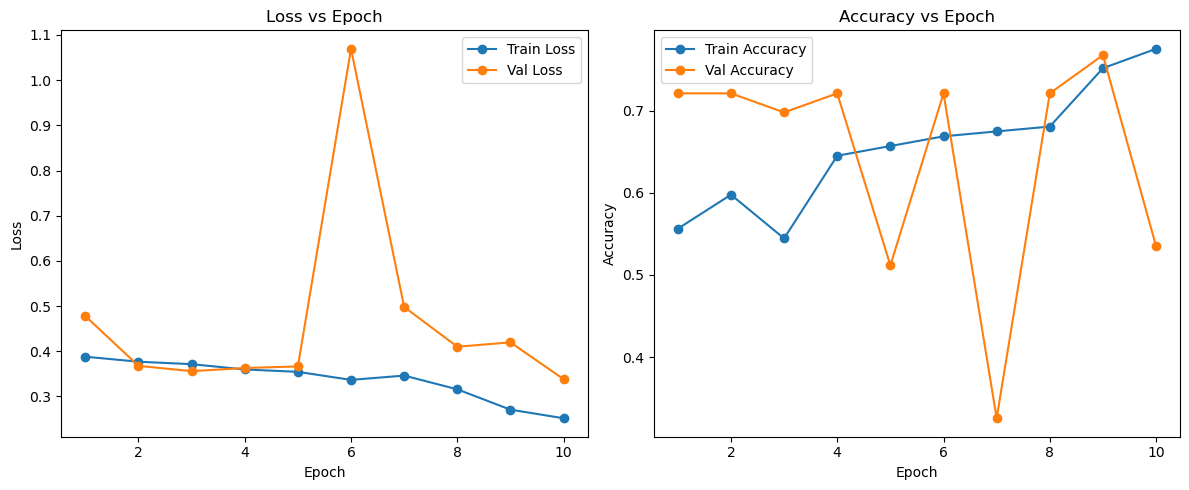

In [1]:
import re
import matplotlib.pyplot as plt

# Load the log file
log_path = "output_12040404.txt"
with open(log_path, "r") as f:
    log = f.read()

# Patterns for training and validation
train_pattern = r"\[TRAIN\]\[JSON\]\[Epoch (\d+)\] Loss: ([\d\.]+) \| Acc: ([\d\.]+)"
val_pattern = r"\[VAL\]\[JSON\]\[Epoch (\d+)\] Loss: ([\d\.]+) \| Acc: ([\d\.]+)"

train_matches = re.findall(train_pattern, log)
val_matches = re.findall(val_pattern, log)

# Convert to lists
train_epochs = [int(m[0]) for m in train_matches]
train_loss = [float(m[1]) for m in train_matches]
train_acc = [float(m[2]) for m in train_matches]

val_epochs = [int(m[0]) for m in val_matches]
val_loss = [float(m[1]) for m in val_matches]
val_acc = [float(m[2]) for m in val_matches]

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_loss, label='Train Loss', marker='o')
plt.plot(val_epochs, val_loss, label='Val Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(val_epochs, val_acc, label='Val Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()


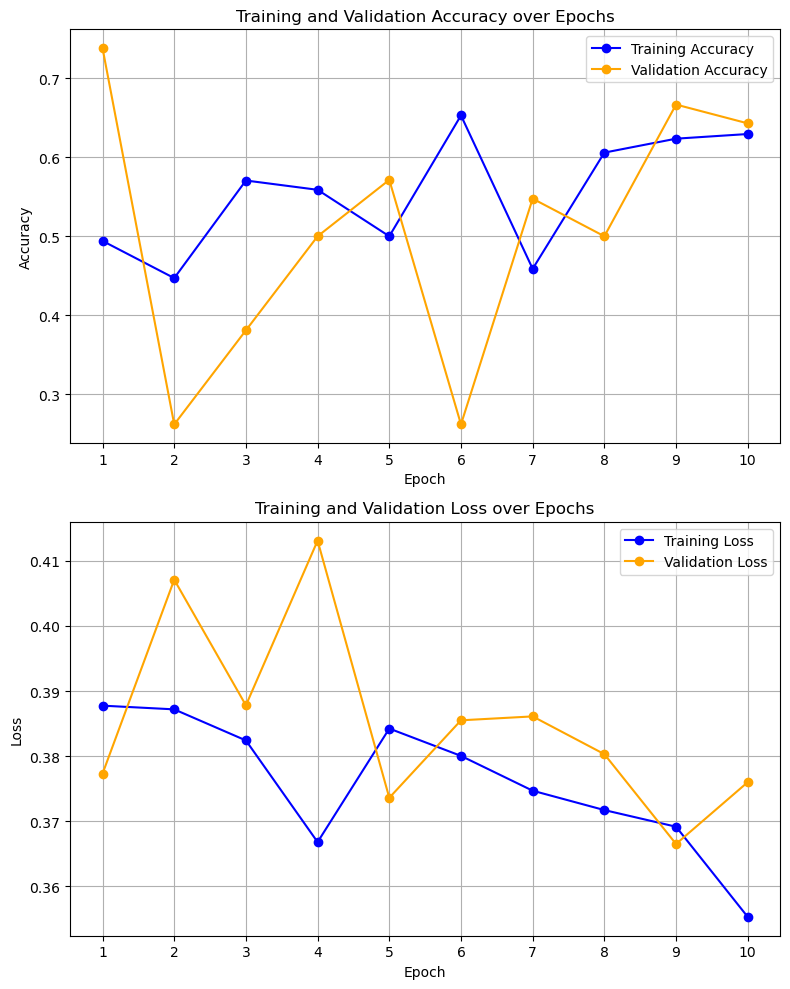

In [15]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

# Load log text
log_path = "output_11974900.txt"
with open(log_path, "r") as file:
    log_text = file.read()

# --- Extract validation accuracy and loss ---
val_acc_pattern = r"\[VAL\]\[Epoch (\d+)\] Loss: ([\d\.]+) \| Accuracy: ([\d\.]+)"
val_matches = re.findall(val_acc_pattern, log_text)
val_epochs = [int(e) for e, _, _ in val_matches]
val_losses = [float(l) for _, l, _ in val_matches]
val_accs = [float(a) for _, _, a in val_matches]

# --- Extract training predictions + compute accuracy ---
train_pattern = r"\[TRAIN\]\[Epoch (\d+)\]\[Batch \d+\] Loss: ([\d\.]+) \| Preds: \[([\d\. ]+)\] \| Targets: \[([\d\. ]+)\]"
train_matches = re.findall(train_pattern, log_text)

train_correct = defaultdict(int)
train_total = defaultdict(int)
train_loss_sum = defaultdict(float)
train_loss_count = defaultdict(int)

for epoch_str, loss_str, preds_str, targets_str in train_matches:
    epoch = int(epoch_str)
    loss = float(loss_str)
    preds = list(map(float, preds_str.strip().split()))
    targets = list(map(float, targets_str.strip().split()))

    preds_binary = [1 if p >= 0.5 else 0 for p in preds]
    targets_binary = [int(t) for t in targets]

    correct = sum(p == t for p, t in zip(preds_binary, targets_binary))
    total = len(targets_binary)

    train_correct[epoch] += correct
    train_total[epoch] += total
    train_loss_sum[epoch] += loss
    train_loss_count[epoch] += 1

train_epochs = sorted(train_correct.keys())
train_accs = [train_correct[e] / train_total[e] for e in train_epochs]
train_losses = [train_loss_sum[e] / train_loss_count[e] for e in train_epochs]

# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Accuracy Plot
axs[0].plot(train_epochs, train_accs, marker="o", label="Training Accuracy", color="blue")
axs[0].plot(val_epochs, val_accs, marker="o", label="Validation Accuracy", color="orange")
axs[0].set_title("Training and Validation Accuracy over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].set_xticks(train_epochs)
axs[0].grid(True)
axs[0].legend()

# Loss Plot
axs[1].plot(train_epochs, train_losses, marker="o", label="Training Loss", color="blue")
axs[1].plot(val_epochs, val_losses, marker="o", label="Validation Loss", color="orange")
axs[1].set_title("Training and Validation Loss over Epochs")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].set_xticks(train_epochs)
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


## Plotting for Multiple Folds

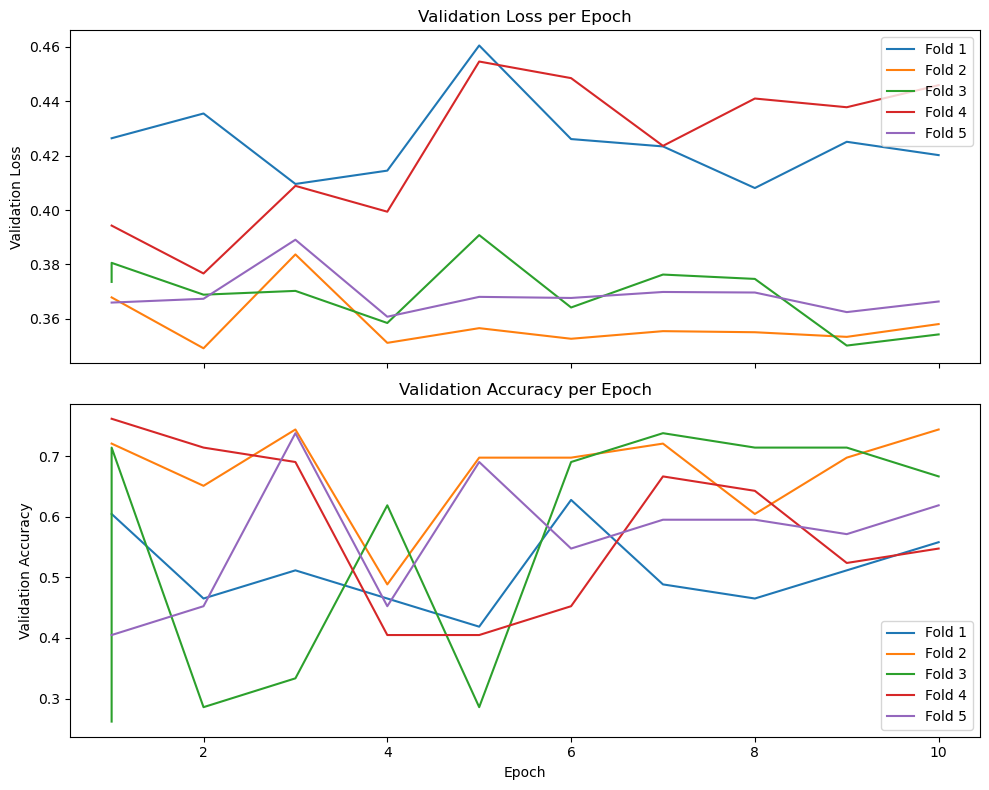

In [20]:
import re
import matplotlib.pyplot as plt
from pathlib import Path

# Define log file paths
log_files = [
    Path("output_11984608.txt"),
    Path("output_11994060.txt")
]

# Initialize lists to store results
folds_data = {}

# Regex patterns
val_metrics_pattern = re.compile(
    r"\[VAL\]\[Fold (\d+)\]\[Epoch (\d+)\] Loss: ([\d.]+) \| Acc: ([\d.]+)"
)

# Parse files
for file_path in log_files:
    with open(file_path, 'r') as f:
        content = f.read()
        for match in val_metrics_pattern.finditer(content):
            fold, epoch, loss, acc = map(lambda x: int(x) if x.isdigit() else float(x), match.groups())
            if fold not in folds_data:
                folds_data[fold] = {"epochs": [], "val_loss": [], "val_acc": []}
            folds_data[fold]["epochs"].append(epoch)
            folds_data[fold]["val_loss"].append(loss)
            folds_data[fold]["val_acc"].append(acc)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for fold, data in sorted(folds_data.items()):
    axs[0].plot(data["epochs"], data["val_loss"], label=f"Fold {fold}")
    axs[1].plot(data["epochs"], data["val_acc"], label=f"Fold {fold}")

axs[0].set_ylabel("Validation Loss")
axs[0].set_title("Validation Loss per Epoch")
axs[0].legend()

axs[1].set_ylabel("Validation Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_title("Validation Accuracy per Epoch")
axs[1].legend()

plt.tight_layout()
plt.show()
